In [2]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import sys
sys.path.append('..')
from security_game.green_security_game import GreenSecurityGame

In [34]:
df = pd.read_csv("lobeke.csv")
df.dropna(inplace=True)

# Lobeke National Park Bounding Box
lat_min, lon_min = 2.05522, 15.8790
lat_max, lon_max = 2.2837, 16.2038

coordinate_rectangle = [lat_min, lat_max, lon_min, lon_max]

schedule_form_kwargs = {
    "schedule_form": True,
    "attacker_animal_value":  2150, 
    "defender_animal_value": 10000, 
    "defender_step_cost": 0, 
    "simple": True,
    "attacker_penalty_factor": 4,
    "defender_penalty_factor": 4,
    "extra_coverage_weight":0.9
}

gsg = GreenSecurityGame(df, coordinate_rectangle, "centroid", num_clusters=5, num_rows=5, num_columns=5)
gsg.generate(num_attackers=2, num_defenders=2, home_base_assignments=[(3,3),(1,1)], num_timesteps=6, generate_utility_matrix=True, general_sum=True, **schedule_form_kwargs)

In [35]:
def solve_general_sum_normal_form(defender_matrix, attacker_matrix):
    """
    Solves a general-sum 2-player normal-form game using LP formulation for commitment to mixed strategies.

    Parameters:
        defender_matrix: numpy array (m x n), defender utility for each (s, t)
        attacker_matrix: numpy array (m x n), attacker utility for each (s, t)

    Returns:
        best_response_t: int, attacker pure strategy (t) against which the best defender mixed strategy commits
        best_defender_strategy: dict, {s: p_s}, optimal mixed strategy over defender pure strategies
        best_defender_utility: float, expected utility for the defender
    """
    num_defender_strategies, num_attacker_strategies = defender_matrix.shape
    best_defender_utility = -float('inf')
    best_response_t = None
    best_defender_strategy = None

    for t in range(num_attacker_strategies):
        model = gp.Model()
        model.setParam("OutputFlag", 0)

        # Variables: p_s for each defender strategy s
        p = model.addVars(num_defender_strategies, lb=0.0, ub=1.0, name="p")

        # Objective: maximize sum_s p_s * u_l(s, t)
        model.setObjective(
            gp.quicksum(p[s] * defender_matrix[s, t] for s in range(num_defender_strategies)),
            GRB.MAXIMIZE
        )

        # Constraint: sum_s p_s = 1
        model.addConstr(gp.quicksum(p[s] for s in range(num_defender_strategies)) == 1, name="prob_sum")

        # Follower best response condition: utility of t >= utility of any t'
        for t_prime in range(num_attacker_strategies):
            lhs = gp.quicksum(p[s] * attacker_matrix[s, t] for s in range(num_defender_strategies))
            rhs = gp.quicksum(p[s] * attacker_matrix[s, t_prime] for s in range(num_defender_strategies))
            model.addConstr(lhs >= rhs, name=f"br_t_{t_prime}")

        model.optimize()

        if model.status == GRB.OPTIMAL:
            defender_utility = model.objVal
            if defender_utility > best_defender_utility:
                best_defender_utility = defender_utility
                best_response_t = t
                best_defender_strategy = {s: p[s].X for s in range(num_defender_strategies)}

    return best_response_t, best_defender_strategy, best_defender_utility

In [36]:
gsg.schedule_form_dict

{'schedules': {0: [({0}, 0), ({4}, 0)], 1: [({1}, 0), ({3}, 0), ({4}, 0)]},
 'target_utilities': array([[-18051.53991201,  -4902.5769956 ,  -3720.93023256,
          -5304.83972344,  -8020.11313639],
        [ -4512.884978  ,  -1225.6442489 ,   -930.23255814,
          -1326.20993086,  -2005.0282841 ],
        [   970.27027027,    263.51351351,    200.        ,
            285.13513514,    431.08108108],
        [  3881.08108108,   1054.05405405,    800.        ,
           1140.54054054,   1724.32432432]]),
 'attacker_utility_matrix': array([[ 970.27027027,  263.51351351,  800.        , 1140.54054054,
         1724.32432432],
        [ 970.27027027, 1054.05405405,  800.        ,  285.13513514,
         1724.32432432],
        [ 970.27027027, 1054.05405405,  800.        , 1140.54054054,
          431.08108108],
        [3881.08108108,  263.51351351,  800.        , 1140.54054054,
          431.08108108],
        [3881.08108108, 1054.05405405,  800.        ,  285.13513514,
          431.

In [37]:
solve_general_sum_normal_form(gsg.schedule_form_dict["defender_utility_matrix"], gsg.schedule_form_dict["attacker_utility_matrix"])

(0,
 {0: 0.21787576698509858,
  1: 0.19905213270142175,
  2: 0.5830721003134797,
  3: 0.0,
  4: 0.0,
  5: 0.0},
 -4512.884978001257)

In [32]:
tu = gsg.schedule_form_dict["target_utilities"]
u_d_uncovered = {i:tu[0][i] for i in range(5)}
u_d_covered = {i:tu[1][i] for i in range(5)}
u_a_covered = {i:tu[2][i] for i in range(5)}
u_a_uncovered = {i:tu[3][i] for i in range(5)}

In [38]:
solve_sse_lp([t.node for t in gsg.targets], [0,1], {0:[0,4], 1:[1,3,4]}, u_d_covered, u_d_uncovered, u_a_covered, u_a_uncovered)

(1,
 {0: 1.0,
  1: 0.10598290598290654,
  2: 0.0,
  3: 0.19905213270142227,
  4: 0.58307210031348},
 -4512.884978001255)

In [12]:
def nash(
    utility_matrix
    ):

    num_rows = len(utility_matrix)
    num_cols = len(utility_matrix[0])

    # Create model
    m = gp.Model("NashLP_ColPlayer")
    m.Params.outputFlag = 0
    # Create variables
    y = [m.addVar(lb=0.0, name=f"y{j}") for j in range(num_cols)]
    z = m.addVar(lb=-float("inf"), name="z")
    m.setObjective(z, GRB.MINIMIZE) 
    # Add constraints 
    for i in range(num_rows):
        m.addConstr(z >= sum(utility_matrix[i][j] * y[j] for j in range(num_cols)), f"c_row_{i}")
    m.addConstr(sum(y) == 1, "sum_y")

    m.optimize()

    return (np.array([v.X for v in y]), [c.Pi for c in m.getConstrs()][:-1], m.ObjVal)


In [13]:
nash(gsg.schedule_form_dict["defender_utility_matrix"])

(array([1., 0., 0., 0., 0.]),
 [0.4169278996865204,
  0.0,
  0.3840199676120578,
  0.0,
  0.1990521327014218,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 -0.25)

# Schedule Finding

In [3]:
import networkx as nx
import itertools
from itertools import combinations
from networkx.algorithms.approximation import steiner_tree

def find_simple_schedules(graph, target_nodes, home_base, defense_time_threshold, num_timesteps):
    defendable_targets = set()
    
    for target in target_nodes:
        # Compute shortest round-trip path length
        path_to_target = nx.shortest_path_length(graph, source=home_base, target=target)
        round_trip_time = 2 * path_to_target  # Going to target + returning
        
        # Check if the defender can reach, defend, and return within time limit
        if round_trip_time + defense_time_threshold <= num_timesteps:
            defendable_targets.add(target)
    
    return defendable_targets


def bfs_shortest_paths(graph, start):
    """Returns shortest path distances from start node using BFS."""
    return nx.single_source_shortest_path_length(graph, start)

def mst_heuristic(graph, subset, dist, start_node):
    """Heuristic: MST cost over subset + return to start."""
    if not subset:
        return float('inf')

    steiner_nodes = list(subset) + [start_node]
    steiner_subgraph = graph.subgraph(steiner_nodes)
    mst = nx.minimum_spanning_tree(steiner_subgraph)

    mst_length = sum(graph[u][v].get('weight', 1) for u, v in mst.edges())

    # Add shortest return path from any node in subset to start
    min_return = min(dist[node].get(start_node, float('inf')) for node in subset)
    return mst_length + min_return

def find_valid_schedules(graph, start_node, target_nodes, max_total_length, dwell_time):
    dist_from_start = {node: nx.single_source_shortest_path_length(graph, node) for node in [start_node] + target_nodes}
    valid_schedules = []

    def backtrack(current_set, remaining_nodes):
        num_nodes = len(current_set)
        if num_nodes > 0:
            extra_wait_time = num_nodes * (dwell_time - 1)
            movement_budget = max_total_length - extra_wait_time
            if movement_budget < 0:
                return

            # est_movement_cost = mst_heuristic(graph, current_set, dist_from_start, start_node)
            est_movement_cost = true_movement_cost(start_node, current_set, dist_from_start)

            if est_movement_cost > movement_budget:
                return

            valid_schedules.append(set(current_set))

        for i, node in enumerate(remaining_nodes):
            backtrack(current_set | {node}, remaining_nodes[i+1:])

    backtrack(set(), target_nodes)
    return valid_schedules

In [ ]:
find_simple_schedules(gsg.graph, [t.node for t in gsg.targets], 12, 2, 6)

In [ ]:
find_valid_schedules(gsg.graph, 12, [t.node for t in gsg.targets], 12, 2)

In [4]:
def bfs_shortest_paths(graph, start):
    return nx.single_source_shortest_path_length(graph, start)

def greedy_movement_cost(start_node, targets, dist):
    """Greedy path cost visiting all targets from start_node (no return)."""
    unvisited = set(targets)
    current = start_node
    total_cost = 0

    while unvisited:
        next_node = min(unvisited, key=lambda x: dist[current].get(x, float('inf')))
        step_cost = dist[current].get(next_node, float('inf'))
        if step_cost == float('inf'):
            return float('inf')
        total_cost += step_cost
        current = next_node
        unvisited.remove(next_node)

    return total_cost

def true_movement_cost(start_node, targets, dist):
    """Exact minimal path cost visiting all targets from start_node (no return)."""
    min_cost = float('inf')

    for perm in itertools.permutations(targets):
        cost = 0
        current = start_node
        for node in perm:
            step_cost = dist[current].get(node, float('inf'))
            if step_cost == float('inf'):
                cost = float('inf')
                break
            cost += step_cost
            current = node
        min_cost = min(min_cost, cost)

    return min_cost

def find_valid_schedules(graph, start_node, target_nodes, max_total_length, dwell_time):
    dist = {node: bfs_shortest_paths(graph, node) for node in [start_node] + target_nodes}
    valid_schedules = []

    def backtrack(current_set, remaining_nodes):
        if current_set:
            dwell_cost = dwell_time * len(current_set)
            # move_cost = greedy_movement_cost(start_node, current_set, dist)
            move_cost = true_movement_cost(start_node, current_set, dist)
            total_cost = dwell_cost + move_cost

            if total_cost <= max_total_length:
                valid_schedules.append(set(current_set))
            else:
                return

        for i, node in enumerate(remaining_nodes):
            backtrack(current_set | {node}, remaining_nodes[i+1:])

    backtrack(set(), target_nodes)
    return valid_schedules

In [ ]:
find_valid_schedules(gsg.graph, 12, [t.node for t in gsg.targets], 7, 2)

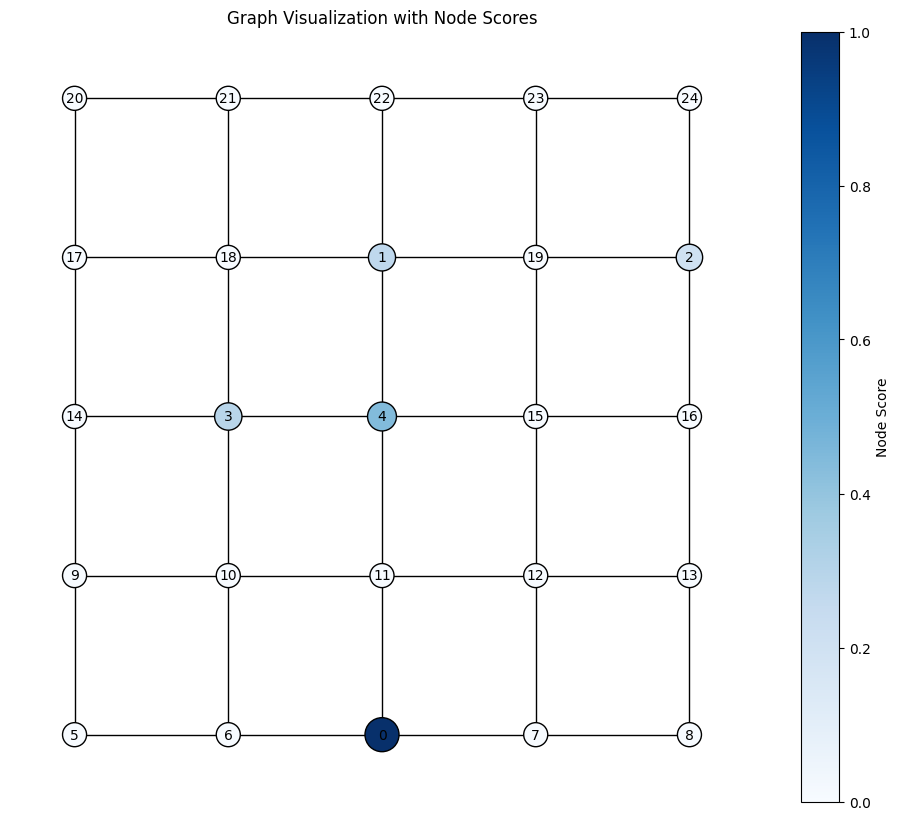

In [5]:
gsg.draw_graph()

In [6]:
def bfs_shortest_paths(graph, start):
    return nx.single_source_shortest_path_length(graph, start)
def get_full_path_with_dwell_and_return(graph, start_node, targets, dwell_time):
    """Returns a full path that visits all targets (with dwell time) and returns to base."""
    min_total_path = None
    min_total_cost = float("inf")

    for perm in itertools.permutations(targets):
        path = [start_node]
        current = start_node
        total_cost = 0
        dwell_steps = []

        try:
            # Move through targets in order
            for node in perm:
                segment = nx.shortest_path(graph, source=current, target=node)
                if segment[0] == current:
                    segment = segment[1:]
                path.extend(segment)
                total_cost += len(segment)
                # Add dwell time (minus 1 because standing on the node already counts as 1)
                path.extend([node] * (dwell_time - 1))
                total_cost += (dwell_time - 1)
                current = node

            # Return to home base
            return_segment = nx.shortest_path(graph, source=current, target=start_node)
            if return_segment[0] == current:
                return_segment = return_segment[1:]
            path.extend(return_segment)
            total_cost += len(return_segment)

            # Update if this path is the best so far
            if total_cost < min_total_cost:
                min_total_cost = total_cost
                min_total_path = list(path)

        except nx.NetworkXNoPath:
            continue  # Skip infeasible permutations

    return min_total_path, min_total_cost
def get_shortest_path_permutation(graph, start_node, targets):
    """Returns the shortest path (node list) visiting all targets from start_node (no return)."""
    min_path = None
    min_cost = float('inf')

    for perm in itertools.permutations(targets):
        path = [start_node]
        current = start_node
        total_path = []
        total_cost = 0
        valid = True

        for node in perm:
            try:
                segment = nx.shortest_path(graph, source=current, target=node)
            except nx.NetworkXNoPath:
                valid = False
                break

            # Avoid duplicating current node
            if segment[0] == current:
                segment = segment[1:]

            total_path += segment
            total_cost += len(segment)
            current = node

        if valid and total_cost < min_cost:
            min_cost = total_cost
            min_path = [start_node] + total_path

    return min_path, min_cost

def find_valid_schedules(graph, start_node, target_nodes, max_total_length, dwell_time):
    valid_schedules = []

    def backtrack(current_set, remaining_nodes):
        if current_set:
            path, total_cost = get_full_path_with_dwell_and_return(graph, start_node, current_set, dwell_time)

            if path is not None and total_cost <= max_total_length:
                valid_schedules.append(set(current_set))

        for i, node in enumerate(remaining_nodes):
            backtrack(current_set | {node}, remaining_nodes[i+1:])

    backtrack(set(), target_nodes)
    return valid_schedules

In [ ]:
find_valid_schedules(gsg.graph, 15, [t.node for t in gsg.targets], 7, 2)

In [ ]:
gsg.graph.edges

# Schedule Form Solving

### Simple Schedule SSE LP

In [18]:
import gurobipy as gp
from gurobipy import GRB

import gurobipy as gp
from gurobipy import GRB

# def solve_sse_lp(targets, resources, A_r, u_d_covered, u_d_uncovered, u_a_covered, u_a_uncovered, t_star):
#     model = gp.Model("SSE_LP")
#     model.setParam("OutputFlag", 0)

#     # Variables
#     c_t = model.addVars(targets, lb=0.0, ub=1.0, name="c_t")  # marginal coverage
#     c_rt = model.addVars(resources, targets, lb=0.0, ub=1.0, name="c_rt")

#     # Objective: Maximize defender utility at t_star
#     model.setObjective(
#         c_t[t_star] * u_d_covered[t_star] + (1 - c_t[t_star]) * u_d_uncovered[t_star],
#         GRB.MAXIMIZE
#     )

#     # Constraint: c_t[t] = sum over r of c_rt[r, t] (only if r can cover t)
#     for t in targets:
#         model.addConstr(
#             c_t[t] == gp.quicksum(c_rt[r, t] for r in resources if t in A_r[r]),
#             name=f"cover_def_{t}"
#         )

#     # Resource constraint: each resource can only assign ≤ 1 total coverage probability
#     for r in resources:
#         model.addConstr(
#             gp.quicksum(c_rt[r, t] for t in A_r[r]) <= 1,
#             name=f"resource_bound_{r}"
#         )

#     # Attacker best response: no t ≠ t_star gives attacker better utility
#     for t in targets:
#         if t == t_star:
#             continue

#         u_att_t = c_t[t] * u_a_covered[t] + (1 - c_t[t]) * u_a_uncovered[t]
#         u_att_t_star = c_t[t_star] * u_a_covered[t_star] + (1 - c_t[t_star]) * u_a_uncovered[t_star]

#         model.addConstr(u_att_t <= u_att_t_star, name=f"attacker_br_{t}")

#     model.optimize()

#     if model.status == GRB.OPTIMAL:
#         coverage = {t: c_t[t].X for t in targets}
#         defender_utility = model.objVal
#         return coverage, defender_utility
#     else:
#         print(f"LP not solved. Status: {model.status}")
#         return None, None


# def find_sse_optimal_target(targets, resources, A_r, u_d_covered, u_d_uncovered, u_a_covered, u_a_uncovered):
#     """
#     Try each possible t* (attacker best response target) and return the optimal defender strategy.

#     Parameters:
#         targets (list[int]): Target node IDs.
#         resources (list[int]): Resource IDs.
#         A_r (dict[int, list[int]]): Maps each resource to list of coverable targets.
#         u_d_covered (dict[int, float]): Defender utility when target t is covered.
#         u_d_uncovered (dict[int, float]): Defender utility when target t is uncovered.
#         u_a_covered (dict[int, float]): Attacker utility when target t is covered.
#         u_a_uncovered (dict[int, float]): Attacker utility when target t is uncovered.

#     Returns:
#         best_target (int): Attacker best response target.
#         best_coverage (dict): Marginal coverage c_t for each target.
#         best_utility (float): Defender utility under the best strategy.
#     """
#     best_target = None
#     best_utility = float("inf")  # Defender wants to minimize attacker value (maximize defender value)
#     best_coverage = {}

#     for t_star in targets:
#         coverage, utility = solve_sse_lp(
#             targets, resources, A_r,
#             u_d_covered, u_d_uncovered,
#             u_a_covered, u_a_uncovered,
#             t_star
#         )

#         if utility is not None and utility < best_utility:
#             best_target = t_star
#             best_utility = utility
#             best_coverage = coverage

#     return best_target, best_coverage, best_utility

def solve_sse_lp(targets, resources, A_r, u_d_covered, u_d_uncovered, u_a_covered, u_a_uncovered):
    """
    Solves the SSE LP for each possible attacker best response t*, returning the defender strategy
    (marginal coverage) that maximizes defender utility.

    Parameters:
        targets: list of target node IDs.
        resources: list of resource IDs.
        A_r: dict {r: list of t} that each resource r can cover.
        u_d_covered: dict {t: float}, defender utility if t is covered.
        u_d_uncovered: dict {t: float}, defender utility if t is uncovered.
        u_a_covered: dict {t: float}, attacker utility if t is covered.
        u_a_uncovered: dict {t: float}, attacker utility if t is uncovered.

    Returns:
        best_t (int): Optimal attacker best response t*.
        best_coverage (dict): Marginal coverage {t: c_t} under defender strategy.
        best_defender_utility (float): Defender utility from committing to this strategy.
    """
    best_t = None
    best_coverage = None
    best_defender_utility = -float("inf")

    for t_star in targets:
        model = gp.Model("SSE_LP")
        model.setParam("OutputFlag", 0)

        # Variables
        c_t = model.addVars(targets, lb=0.0, ub=1.0, name="c_t")  # marginal coverage
        c_rt = model.addVars(resources, targets, lb=0.0, ub=1.0, name="c_rt")

        # Objective: Maximize defender utility at t_star
        model.setObjective(
            c_t[t_star] * u_d_covered[t_star] + (1 - c_t[t_star]) * u_d_uncovered[t_star],
            GRB.MAXIMIZE
        )

        # Coverage definition
        for t in targets:
            model.addConstr(
                c_t[t] == gp.quicksum(c_rt[r, t] for r in resources if t in A_r[r]),
                name=f"cover_def_{t}"
            )

        # Resource constraints
        for r in resources:
            model.addConstr(
                gp.quicksum(c_rt[r, t] for t in A_r[r]) <= 1,
                name=f"resource_bound_{r}"
            )

        # Attacker best response constraints
        for t in targets:
            if t == t_star:
                continue

            u_att_t = c_t[t] * u_a_covered[t] + (1 - c_t[t]) * u_a_uncovered[t]
            u_att_star = c_t[t_star] * u_a_covered[t_star] + (1 - c_t[t_star]) * u_a_uncovered[t_star]
            model.addConstr(u_att_t <= u_att_star, name=f"attacker_br_{t}")

        model.optimize()

        if model.status == GRB.OPTIMAL:
            defender_utility = model.objVal
            if defender_utility > best_defender_utility:
                best_t = t_star
                best_defender_utility = defender_utility
                best_coverage = {t: c_t[t].X for t in targets}

    return best_t, best_coverage, best_defender_utility

In [8]:
targets = gsg.targets
target_nodes = [t.node for t in targets]
resources = [0,1]
starts = [12,18]
A_r = {d:list(find_simple_schedules(gsg.graph, target_nodes, starts[d], 2, 6)) for d in resources}
u_d_uncovered = {t.node:-t.value for t in targets}
u_d_covered = {t:v/3 for t,v in u_d_uncovered.items()}
u_a_uncovered = {t.node:t.value for t in targets}
u_a_covered = {t:v/3 for t,v in u_a_uncovered.items()}

find_sse_optimal_target(target_nodes, resources, A_r, u_d_covered, u_d_uncovered, u_a_covered, u_a_uncovered)

targets
[0, 1, 2, 3, 4]
resources
[0, 1]
A_r
{0: [0, 4], 1: [1, 3, 4]}
u d covered
{0: -0.3333333333333333, 1: -0.09052924791086352, 2: -0.06870937790157845, 3: -0.0979572887650882, 4: -0.14809656453110492}
u d uncovered
{0: -1.0, 1: -0.27158774373259054, 2: -0.20612813370473537, 3: -0.2938718662952646, 4: -0.44428969359331477}
u a covered
{0: 0.3333333333333333, 1: 0.09052924791086352, 2: 0.06870937790157845, 3: 0.0979572887650882, 4: 0.14809656453110492}
u a uncovered
{0: 1.0, 1: 0.27158774373259054, 2: 0.20612813370473537, 3: 0.2938718662952646, 4: 0.44428969359331477}
0
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2455389
Academic license 2455389 - for non-commercial use only - registered to jc___@columbia.edu
{0: 1.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 1.0} -0.33333333333333326
1
LP not solved. Status: 3
None None
2
LP not solved. Status: 3
None None
3
LP not solved. Status: 3
None None
4
{0: 1.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.3746081504702195} -0.3333

(4,
 {0: 1.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.3746081504702195},
 -0.3333333333333333)

# Defender BR Oracle for Schedule Form

In [9]:
def defender_best_response_schedule_form(resources, schedules_by_resource, expected_target_values):
    """
    Defender best response in schedule-form double oracle using attacker-strategy-dependent expected target values.

    Parameters:
        resources: list of resource IDs (e.g., [0, 1, 2])
        schedules_by_resource: dict {r: list of sets}, where each set is a schedule of target nodes
        expected_target_values: dict {t: float}, representing the attack-weighted expected utility of defending t

    Returns:
        selected_schedules: dict {r: selected schedule}
        covered_targets: list of targets covered
        defender_utility: float, total expected defender utility
    """

    model = gp.Model("DefenderBR_ScheduleForm")
    model.setParam("OutputFlag", 0)

    all_targets = set()
    for scheds in schedules_by_resource.values():
        for s in scheds:
            all_targets.update(s)

    # Decision variables
    x = {}  # Binary selection: x[r, i] = 1 if resource r chooses schedule i
    for r in resources:
        for i, sched in enumerate(schedules_by_resource[r]):
            x[r, i] = model.addVar(vtype=GRB.BINARY, name=f"x_{r}_{i}")

    g = {}  # g[t] = 1 if target t is covered
    for t in all_targets:
        g[t] = model.addVar(vtype=GRB.BINARY, name=f"g_{t}")

    # Constraint 1: Each resource chooses exactly one schedule
    for r in resources:
        model.addConstr(gp.quicksum(x[r, i] for i in range(len(schedules_by_resource[r]))) == 1)

    # Constraint 2: g[t] ≤ sum of x[r, i] where schedule i for r includes t
    for t in all_targets:
        model.addConstr(
            g[t] <= gp.quicksum(
                x[r, i] for r in resources
                for i, sched in enumerate(schedules_by_resource[r])
                if t in sched
            )
        )

    # Objective: maximize total expected utility from covered targets
    model.setObjective(
        gp.quicksum(expected_target_values[t] * g[t] for t in all_targets),
        GRB.MINIMIZE
    )

    model.optimize()

    if model.Status != GRB.OPTIMAL:
        print("Warning: Model did not solve to optimality.")
        return None, None, None

    # Retrieve defender strategies
    selected_schedules = {
        r: schedules_by_resource[r][i]
        for r in resources
        for i in range(len(schedules_by_resource[r]))
        if x[r, i].X > 0.5
    }

    covered_targets = [t for t in all_targets if g[t].X > 0.5]
    utility = model.ObjVal

    return list(selected_schedules.values()), covered_targets, utility

In [84]:
resources = [0,1]
argets = gsg.targets
target_nodes = [t.node for t in targets]
all_targets = set(target_nodes)
starts = [12,18]
schedules_by_resource = {d:find_valid_schedules(gsg.graph, starts[d], target_nodes, 7, 2) for d in resources}
expected_target_values = {t:v/3 for t,v in u_d_uncovered.items()}

In [85]:
schedules_by_resource

{0: [{0}, {1}, {2}, {3}, {4}],
 1: [{1}, {1, 3}, {1, 3, 4}, {1, 4}, {2}, {3}, {3, 4}, {4}]}

In [12]:
expected_target_values

{0: -0.3333333333333333,
 1: -0.09052924791086352,
 2: -0.06870937790157845,
 3: -0.0979572887650882,
 4: -0.14809656453110492}

In [13]:
defender_best_response_schedule_form(resources, all_targets, schedules_by_resource, expected_target_values)

TypeError: defender_best_response_schedule_form() takes 3 positional arguments but 4 were given

In [ ]:
sum(D_a[t] * (target_utilities[1, t] if any(t in s for s in BR_d) else target_utilities[0, t]) for t in range(len(D_a)))

# Schedule Form Vector Algo

In [52]:
def get_target_utility_matrix(game, penalty_factor=3):
    """
    Returns a 4 x num_targets utility matrix:
        Row 0: Defender utility (target uncovered)
        Row 1: Defender utility (target covered)
        Row 2: Attacker utility (target covered)
        Row 3: Attacker utility (target uncovered)

    Parameters:
        game: An object with a .targets list, where each target has a .value attribute
        penalty_factor: Float for scaling the defender utility when target is covered (default=3)

    Returns:
        np.ndarray of shape (4, num_targets)
    """
    values = np.array([t.value for t in game.targets])
    
    defender_uncovered = -values
    defender_covered = -values / penalty_factor
    attacker_covered = values / penalty_factor
    attacker_uncovered = values

    return np.vstack([
        defender_uncovered,
        defender_covered,
        attacker_covered,
        attacker_uncovered
    ])

def get_target_utility_matrix_randomized(game, seed=42):
    """
    Returns a 4 x num_targets utility matrix with randomized covered values between 0 and the uncovered value.
    Enforces zero-sum (attacker utility = - defender utility)

        Row 0: Defender utility (target uncovered)
        Row 1: Defender utility (target covered) — randomly sampled between 0 and uncovered
        Row 2: Attacker utility (target covered) — negative of defender covered
        Row 3: Attacker utility (target uncovered) — negative of defender uncovered

    Parameters:
        game: An object with a .targets list, where each target has a .value attribute
        seed: Integer, random seed for reproducibility

    Returns:
        np.ndarray of shape (4, num_targets)
    """
    rng = np.random.default_rng(seed)
    values = np.array([t.value for t in game.targets])

    defender_uncovered = -values
    defender_covered = np.array([
        rng.uniform(low=min(0, u), high=max(0, u)) for u in defender_uncovered
    ])

    attacker_covered = -defender_covered
    attacker_uncovered = -defender_uncovered

    return np.vstack([
        defender_uncovered,
        defender_covered,
        attacker_covered,
        attacker_uncovered
    ])

import itertools

def generate_defender_actions(schedule_dict):
    """
    Generates all possible joint defender strategies from a dictionary mapping
    each defender to their list of schedule sets.

    Parameters:
        schedule_dict (dict[int, list[set]]): Maps defender index to list of their valid schedules

    Returns:
        list[list[set]]: Each inner list represents one complete defender action,
                         containing one schedule per defender
    """
    # Get a list of schedule lists in order of defender indices
    sorted_defenders = sorted(schedule_dict.keys())
    schedule_lists = [schedule_dict[d] for d in sorted_defenders]

    # Cartesian product to get all combinations
    all_combinations = list(itertools.product(*schedule_lists))

    # Convert tuples to lists (if preferred)
    return [list(comb) for comb in all_combinations]

def generate_schedule_game_matrix(attacker_actions, defender_actions, utility_matrix):
    """
    Builds utility matrices for all combinations of defender and attacker actions.

    Parameters:
        attacker_actions (list[int]): List of target nodes (attacker strategies).
        defender_actions (list[list[set]]): Each outer list is one defender action;
            inner list is per-defender selected schedule (a set of targets).
        utility_matrix (np.ndarray): 4 x num_targets array:
            [0]: defender utility if uncovered
            [1]: defender utility if covered
            [2]: attacker utility if covered
            [3]: attacker utility if uncovered

    Returns:
        tuple:
            - defender_util_matrix (np.ndarray): shape (len(defender_actions), len(attacker_actions))
            - attacker_util_matrix (np.ndarray): same shape
    """
    num_defender_actions = len(defender_actions)
    num_attacker_actions = len(attacker_actions)

    defender_util_matrix = np.zeros((num_defender_actions, num_attacker_actions))
    attacker_util_matrix = np.zeros((num_defender_actions, num_attacker_actions))

    for i, d_action in enumerate(defender_actions):
        # Union of all targets covered in this defender strategy
        covered_targets = set().union(*d_action)


        for j, atk_target in enumerate(attacker_actions):
            if atk_target in covered_targets:
                defender_util_matrix[i, j] = utility_matrix[1][atk_target]  # defender covered
                attacker_util_matrix[i, j] = utility_matrix[2][atk_target]  # attacker covered
            else:
                defender_util_matrix[i, j] = utility_matrix[0][atk_target]  # defender uncovered
                attacker_util_matrix[i, j] = utility_matrix[3][atk_target]  # attacker uncovered

    return defender_util_matrix, attacker_util_matrix

def attacker_best_response(all_targets, defender_distribution, defender_actions, target_values_matrix, negative=True):
    """
    Computes the best target for the attacker to attack against a defender mixed strategy.

    Parameters:
        all_targets (list[int]): All possible targets in the game (not limited to subgame).
        defender_distribution (list[float]): Probabilities over defender schedule assignments.
        defender_actions (list[list[set]]): List of defender strategies, each is a list of sets (schedules for each defender).
        target_values_matrix (np.ndarray): 4 x num_targets matrix.
        negative (bool): If True, returns negative utility for attacker (for zero-sum compatibility).

    Returns:
        best_target (int): Target with highest expected attacker utility.
        best_value (float): Expected value of attacking best_target against defender strategy.
    """
    # Step 1: Compute marginal coverage probability for each target
    target_coverage = {t: 0.0 for t in all_targets}
    for i, defender_action in enumerate(defender_actions):
        prob = defender_distribution[i]
        covered_targets = set().union(*defender_action)
        for t in covered_targets:
            if t in target_coverage:
                target_coverage[t] += prob

    # Step 2: Compute expected value for attacker for each target
    expected_utilities = {}
    for t in all_targets:
        p = target_coverage.get(t, 0.0)
        u_att_covered = target_values_matrix[2, t]
        u_att_uncovered = target_values_matrix[3, t]
        expected_utilities[t] = p * u_att_covered + (1 - p) * u_att_uncovered

    # Step 3: Return target with highest expected utility
    best_target = max(expected_utilities, key=expected_utilities.get)
    best_value = expected_utilities[best_target]

    if negative:
        best_value = -best_value

    return best_target, best_value

def nash(
    utility_matrix
    ):

    num_rows = len(utility_matrix)
    num_cols = len(utility_matrix[0])

    # Create model
    m = gp.Model("NashLP_ColPlayer")
    m.Params.outputFlag = 0
    # Create variables
    y = [m.addVar(lb=0.0, name=f"y{j}") for j in range(num_cols)]
    z = m.addVar(lb=-float("inf"), name="z")
    m.setObjective(z, GRB.MINIMIZE) 
    # Add constraints 
    for i in range(num_rows):
        m.addConstr(z >= sum(utility_matrix[i][j] * y[j] for j in range(num_cols)), f"c_row_{i}")
    m.addConstr(sum(y) == 1, "sum_y")

    m.optimize()

    return (np.array([v.X for v in y]), [c.Pi for c in m.getConstrs()][:-1], m.ObjVal)


def compute_expected_defender_utilities(attacker_distribution, attacker_actions, target_values_matrix, all_targets):
    """
    Computes expected defender utility for each target given attacker distribution over attack targets.

    Parameters:
        attacker_distribution (list[float]): Probabilities for attacking each action (index corresponds to attacker_actions).
        attacker_actions (list[int]): List of target nodes corresponding to attacker strategies.
        target_values_matrix (np.ndarray): 4 x num_targets matrix.
            Row 0: defender utility if target is uncovered.
            Row 1: defender utility if target is covered.
        all_targets (list[int]): Full list of target node IDs.

    Returns:
        expected_utilities (dict[int, float]): Mapping from target index to expected defender utility.
    """
    expected_utilities = {t: 0.0 for t in all_targets}

    for i, target in enumerate(attacker_actions):
        prob = attacker_distribution[i]
        u_covered = target_values_matrix[1, target]
        u_uncovered = target_values_matrix[0, target]
        expected_utilities[target] = prob * u_covered + (1 - prob) * u_uncovered

    return expected_utilities

def get_score(target, schedule_assignment, target_utilities):
    """
    Returns the defender utility for a given target and defender schedule assignment.
    
    Args:
        target (int): Target node to evaluate.
        schedule_assignment (list[set]): One schedule per defender (list of sets of targets).
        target_utilities (np.ndarray): 4 x num_targets utility matrix.
                                       Row 0: Defender uncovered
                                       Row 1: Defender covered
                                       Row 2: Attacker covered
                                       Row 3: Attacker uncovered

    Returns:
        float: Defender utility value for the target, depending on whether it is covered.
    """
    is_covered = any(target in schedule for schedule in schedule_assignment)
    if is_covered:
        return target_utilities[1][target]  # Defender covered utility
    else:
        return target_utilities[0][target]  # Defender uncovered utility
    

def expand_subgame(U, A_a, A_d, BR_a_in_U, BR_d_in_U, target_utilities):
    """
    Expands the utility matrix U when A and/or B grow.
    
    Parameters:
    - U (np.array): Existing utility matrix of shape (n, m).
    - A (list): Updated list of attacker strategies.
    - B (list): Updated list of defender strategies.
    - A_expanded (bool): Flag indicating if A was expanded.
    - B_expanded (bool): Flag indicating if B was expanded.
    - get_score (function): Function to compute score for new pairs.
    
    Returns:
    - np.array: Updated utility matrix with new entries filled.
    """
    n, m = U.shape  # Get current matrix size
    
    if BR_a_in_U and BR_d_in_U:
        return U  # No expansion needed
    
    # Create new expanded matrix with placeholder values (assuming scores are non-positive)
    if not BR_a_in_U:
        new_m = m + 1
    else:
        new_m = m

    if not BR_d_in_U:
        new_n = n + 1
    else:
        new_n = n
        
    new_U = np.full((new_n, new_m), fill_value=1, dtype=U.dtype)
    
    # Copy over the existing values
    new_U[:n, :m] = U 

    # Compute new **column** (if A_a expanded)
    if not BR_a_in_U:
        for i in range(new_n):  # Iterate over all rows (old + new)
            new_U[i, new_m-1] = get_score(A_a[-1], A_d[i], target_utilities)
    
    # Compute new **row** (if A_d expanded)
    if not BR_d_in_U:
        for i in range(new_m):  # Iterate over all columns (old + new)
            new_U[new_n-1, i] = get_score(A_a[i], A_d[-1], target_utilities)

    return new_U

In [15]:
get_target_utility_matrix(gsg)

array([[-1.        , -0.27158774, -0.20612813, -0.29387187, -0.44428969],
       [-0.33333333, -0.09052925, -0.06870938, -0.09795729, -0.14809656],
       [ 0.33333333,  0.09052925,  0.06870938,  0.09795729,  0.14809656],
       [ 1.        ,  0.27158774,  0.20612813,  0.29387187,  0.44428969]])

In [16]:
generate_defender_actions(schedules_by_resource)

[[{0}, {1}],
 [{0}, {1, 2}],
 [{0}, {1, 3}],
 [{0}, {1, 3, 4}],
 [{0}, {1, 4}],
 [{0}, {2}],
 [{0}, {3}],
 [{0}, {3, 4}],
 [{0}, {4}],
 [{0, 4}, {1}],
 [{0, 4}, {1, 2}],
 [{0, 4}, {1, 3}],
 [{0, 4}, {1, 3, 4}],
 [{0, 4}, {1, 4}],
 [{0, 4}, {2}],
 [{0, 4}, {3}],
 [{0, 4}, {3, 4}],
 [{0, 4}, {4}],
 [{1}, {1}],
 [{1}, {1, 2}],
 [{1}, {1, 3}],
 [{1}, {1, 3, 4}],
 [{1}, {1, 4}],
 [{1}, {2}],
 [{1}, {3}],
 [{1}, {3, 4}],
 [{1}, {4}],
 [{1, 4}, {1}],
 [{1, 4}, {1, 2}],
 [{1, 4}, {1, 3}],
 [{1, 4}, {1, 3, 4}],
 [{1, 4}, {1, 4}],
 [{1, 4}, {2}],
 [{1, 4}, {3}],
 [{1, 4}, {3, 4}],
 [{1, 4}, {4}],
 [{2}, {1}],
 [{2}, {1, 2}],
 [{2}, {1, 3}],
 [{2}, {1, 3, 4}],
 [{2}, {1, 4}],
 [{2}, {2}],
 [{2}, {3}],
 [{2}, {3, 4}],
 [{2}, {4}],
 [{3}, {1}],
 [{3}, {1, 2}],
 [{3}, {1, 3}],
 [{3}, {1, 3, 4}],
 [{3}, {1, 4}],
 [{3}, {2}],
 [{3}, {3}],
 [{3}, {3, 4}],
 [{3}, {4}],
 [{3, 4}, {1}],
 [{3, 4}, {1, 2}],
 [{3, 4}, {1, 3}],
 [{3, 4}, {1, 3, 4}],
 [{3, 4}, {1, 4}],
 [{3, 4}, {2}],
 [{3, 4}, {3}],
 [{3, 4},

In [78]:
from collections import defaultdict
def double_oracle(schedule_form_di, initial_subgame_size=2, eps=1e-6, verbose=True):
    target_utilities = schedule_form_di["target_utilities"]
    schedules = schedule_form_di["schedules"]
    targets = list(range(target_utilities.shape[1]))
    num_defenders = len(list(schedules.keys()))
    resources = list(range(num_defenders))

    schedule_assignments = generate_defender_actions(schedules)
    A_d = schedule_assignments[:initial_subgame_size]
    A_a = targets[:initial_subgame_size]
    print("====================================================")
    print("A_a and A_d")
    print(A_a)
    print(A_d)

    U_subgame = generate_schedule_game_matrix(A_a, A_d, target_utilities)[0]
    print("Initial U_subgame")
    print(U_subgame)

    gap = np.inf
    c = 0
    
    if verbose:
        print("running...")
        
    while gap > eps:
        BR_a_in_U = False
        BR_d_in_U = False
        
        D_a, D_d, u_s = nash(U_subgame)
        print("----------------")
        print("D_a, D_d, u_s")
        print(D_a)
        print(D_d)
        print(u_s)

        print(A_d, D_d, target_utilities)
        BR_a, u_BRa_Dd = attacker_best_response(targets, D_d, A_d, target_utilities)
        expected_target_values = compute_expected_defender_utilities(D_a, A_a, target_utilities, targets)
        # print(expected_target_values)
        BR_d, _, _ = defender_best_response_schedule_form(resources, schedules_by_resource, expected_target_values)
        print("----------------")
        print("BR A, BR D")
        print(BR_a)
        print(BR_d)

        u_BRd_Da = sum(
            D_a[i] * (target_utilities[1, target] if any(target in s for s in BR_d) else target_utilities[0, target])
            for i, target in enumerate(A_a)
        )

        print("----------------")
        print("U(BR A, Dd), U(BR D, Da)")
        print(u_BRa_Dd)
        print(u_BRd_Da)

        gap = abs(u_BRa_Dd - u_BRd_Da)

        if BR_a not in A_a:
            A_a.append(BR_a)
        else:
            BR_a_in_U = True
        print("----------------")
        print("BR A in U, A_a")
        print(BR_a_in_U)
        print(A_a)

        for existing in A_d:
            if all(sched in existing for sched in BR_d) and all(sched in BR_d for sched in existing):
                BR_d_in_U = True
                break
        
        if not BR_d_in_U:
            A_d.append(BR_d)

        print("----------------")
        print("BR D in U, A_d")
        print(BR_d_in_U)
        print(A_d)

        print(f"Old subgame shape: {U_subgame.shape}")
        U_subgame = expand_subgame(U_subgame, A_a, A_d, BR_a_in_U, BR_d_in_U, target_utilities)
        print(f"New subgame shape: {U_subgame.shape}")
        print("----------------")
        print("U Subgame")
        print(U_subgame)
        
        c+=1

        if verbose:
            print(f" U(D_d, BR A): {u_BRa_Dd}, U(D_a, BR D): {u_BRd_Da}")
            print(f"Current Gap: {gap}")
            
    return D_a, D_d, u_s, c

In [91]:
schedule_form_di = {"target_utilities":get_target_utility_matrix_randomized(gsg), "schedules":schedules_by_resource}
double_oracle(schedule_form_di)

A_a and A_d
[0, 1]
[[{0}, {1}], [{0}, {1, 3}]]
Initial U_subgame
[[-0.22604395 -0.26822844]
 [-0.22604395 -0.26822844]]
running...
----------------
D_a, D_d, u_s
[0. 1.]
[0.0, 1.0]
-0.26822843814050246
[[{0}, {1}], [{0}, {1, 3}]] [0.0, 1.0] [[-1.         -0.47802198 -0.37912088 -0.36263736 -0.70604396 -0.97802198
  -0.46703297]
 [-0.22604395 -0.26822844 -0.05360848 -0.10974566 -0.63955061 -0.02384188
  -0.11155563]
 [ 0.22604395  0.26822844  0.05360848  0.10974566  0.63955061  0.02384188
   0.11155563]
 [ 1.          0.47802198  0.37912088  0.36263736  0.70604396  0.97802198
   0.46703297]]
----------------
BR A, BR D
5
[{0}, {1, 3, 4}]
----------------
U(BR A, Dd), U(BR D, Da)
-0.978021978021978
-0.26822843814050246
----------------
BR A in U, A_a
False
[0, 1, 5]
----------------
BR D in U, A_d
False
[[{0}, {1}], [{0}, {1, 3}], [{0}, {1, 3, 4}]]
Old subgame shape: (2, 2)
New subgame shape: (3, 3)
----------------
U Subgame
[[-0.22604395 -0.26822844 -0.97802198]
 [-0.22604395 -0.268228

(array([0., 0., 1.]), [0.0, 1.0, 0.0], -0.978021978021978, 2)

In [88]:
schedule_form_di = {"target_utilities":get_target_utility_matrix_randomized(gsg), "schedules":schedules_by_resource}
schedule_form_di["schedules"]

{0: [{0}, {1}, {2}, {3}, {4}],
 1: [{1}, {1, 3}, {1, 3, 4}, {1, 4}, {2}, {3}, {3, 4}, {4}]}

In [89]:
U = generate_schedule_game_matrix([0,1,2,3,4,5,6], generate_defender_actions(schedule_form_di["schedules"]), schedule_form_di["target_utilities"])[0]

In [90]:
nash(U)

(array([0., 0., 0., 0., 0., 1., 0.]),
 [1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 -0.978021978021978)

In [62]:
schedule_form_di

{'target_utilities': array([[-1.        , -0.27158774, -0.20612813, -0.29387187, -0.44428969],
        [-0.22604395, -0.15239374, -0.02914695, -0.08893502, -0.40244767],
        [ 0.22604395,  0.15239374,  0.02914695,  0.08893502,  0.40244767],
        [ 1.        ,  0.27158774,  0.20612813,  0.29387187,  0.44428969]]),
 'schedules': {0: [{0}, {0, 4}, {1}, {1, 4}, {2}, {3}, {3, 4}, {4}],
  1: [{1}, {1, 2}, {1, 3}, {1, 3, 4}, {1, 4}, {2}, {3}, {3, 4}, {4}]}}

In [65]:
U

array([[-0.22604395, -0.15239374, -0.20612813, -0.29387187, -0.44428969],
       [-0.22604395, -0.15239374, -0.02914695, -0.29387187, -0.44428969],
       [-0.22604395, -0.15239374, -0.20612813, -0.08893502, -0.44428969],
       [-0.22604395, -0.15239374, -0.20612813, -0.08893502, -0.40244767],
       [-0.22604395, -0.15239374, -0.20612813, -0.29387187, -0.40244767],
       [-0.22604395, -0.27158774, -0.02914695, -0.29387187, -0.44428969],
       [-0.22604395, -0.27158774, -0.20612813, -0.08893502, -0.44428969],
       [-0.22604395, -0.27158774, -0.20612813, -0.08893502, -0.40244767],
       [-0.22604395, -0.27158774, -0.20612813, -0.29387187, -0.40244767],
       [-0.22604395, -0.15239374, -0.20612813, -0.29387187, -0.40244767],
       [-0.22604395, -0.15239374, -0.02914695, -0.29387187, -0.40244767],
       [-0.22604395, -0.15239374, -0.20612813, -0.08893502, -0.40244767],
       [-0.22604395, -0.15239374, -0.20612813, -0.08893502, -0.40244767],
       [-0.22604395, -0.15239374, -0.2

In [67]:
generate_defender_actions(schedule_form_di["schedules"])[10]

[{0, 4}, {1, 2}]

In [69]:
schedule_form_di["target_utilities"]

array([[-1.        , -0.27158774, -0.20612813, -0.29387187, -0.44428969],
       [-0.22604395, -0.15239374, -0.02914695, -0.08893502, -0.40244767],
       [ 0.22604395,  0.15239374,  0.02914695,  0.08893502,  0.40244767],
       [ 1.        ,  0.27158774,  0.20612813,  0.29387187,  0.44428969]])